# Assignment# 2: Logistic Regression with Bagging and Stacking

In [949]:
 
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, average_precision_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

np.random.seed(0)

# Evaluation Metrics

In [950]:
def evaluate_model(model, X,y):
    y_pred = model.predict(X)
    y_pred_proba = model.predict_proba(X)

    if len(y_pred_proba.shape) == 2:
        y_pred_proba = y_pred_proba[:,1] # only keep the probability of the positive class
    
    return {
        'accuracy': accuracy_score(y, y_pred),
        'sensitivity': recall_score(y, y_pred),
        'specificity': recall_score(y, y_pred, pos_label=0),
        'precision': precision_score(y, y_pred),
        'f1_score': f1_score(y, y_pred),
        'auroc': roc_auc_score(y, y_pred_proba),
        'aupr': average_precision_score(y, y_pred_proba)
    }



In [951]:
# Draw violin plots for each performance metric for the 9 bagging LR learners
import seaborn as sns
import matplotlib.pyplot as plt

def draw_violin_plots(LR_evals):
    fig, axes = plt.subplots(1, 7, figsize=(35, 10))
    axes = axes.flatten()
    metrics = ['accuracy', 'sensitivity', 'specificity', 'precision', 'f1_score', 'auroc', 'aupr']
    for i, metric in enumerate(metrics):
        sns.violinplot(data=LR_evals[metric], ax=axes[i])
        axes[i].set_title(f'{metric.capitalize()} distribution')
    plt.tight_layout()
    plt.show()


# Data Preprocessing

`Data Cleaning`

In [952]:
def replace_missing_values(df):

    # Replace missing numerical values with the mean of the column
    num_cols = df.select_dtypes(include=[np.number]).columns
    df[num_cols] = df[num_cols].fillna(df[num_cols].mean())

    # Replace missing categorical values with the mode of the column
    # cat_cols = cols.diff(num_cols)
    cat_cols = df.columns.difference(num_cols)
    if(cat_cols.size > 0):
        df[cat_cols] = df[cat_cols].fillna(df[cat_cols].mode().iloc[0])

    # return df

def drop_duplicates(df):
    # Drop duplicates
    df.drop_duplicates(inplace=True)
    # return df

def drop_target_nan(df, target):
    # Drop rows with missing target
    df.dropna(subset=[target], inplace=True)
    # return df


`creation of i/o features`

In [953]:
def create_io_features(df, target):
    # Create X and y
    X = df.drop(columns=[target])
    y = df[target]
    return X, y

`conversion of features into numeric values`

In [954]:
from sklearn.preprocessing import LabelEncoder

def encode_target(y):
    le = LabelEncoder()
    y = le.fit_transform(y)
    return y

def encode_categorical_features(X):
    # Encode categorical features
    nums_cols = X.select_dtypes(include=[np.number]).columns
    cat_cols = X.columns.difference(nums_cols)
    X[cat_cols] = X[cat_cols].astype('category')
    X = pd.get_dummies(X)
    
    return X

`scaling`

In [955]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

def scaling(X, scaler = StandardScaler()):

    # only scale numerical features which are not one-hot encoded
    one_hot_encoded_features = [col for col in X.columns if set(X[col].unique()) == {0, 1}]
    num_cols = X.columns.difference(one_hot_encoded_features)
    
    scaled_features = X.copy()
    scaled_features[num_cols] = scaler.fit_transform(X[num_cols])
    
    return scaled_features

# Feature Selection

`Feature Selection`

In [956]:
from sklearn.feature_selection import mutual_info_classif
    
# feature selection based on correlation or info gain 
def feature_selection(X, y, threshold1=0.005, threshold2=0.9, method="corr"):
    
    if method == "corr":
        # Calculate correlation with target
        corr = X.corrwith(y)
        # Select features with correlation above threshold
        selected_features = corr[abs(corr) > threshold1].index
        
        # Drop highly correlated features
        corr_matrix = X[selected_features].corr().abs()
        upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
        to_drop = [column for column in upper.columns if any(upper[column] > threshold2)]
        selected_features = selected_features.difference(to_drop)
        return X[selected_features]
    else:
        # Calculate mutual information with target
        ig = mutual_info_classif(X, y)
        # Select features with mutual information above threshold
        selected_features = X.columns[ig > threshold1]
        return X[selected_features]
    

`Data Processing Uint`

In [957]:
def preprocessor(df, target):
    # Replace missing values
    replace_missing_values(df)

    # Drop duplicates
    # drop_duplicates(df)

    # Drop rows with missing target
    drop_target_nan(df, target)

    # Create X and y
    X, y = create_io_features(df, target)

    # Encode target
    y = encode_target(y)

    # Encode categorical features
    X = encode_categorical_features(X)

    # Scale features
    X = scaling(X)
    X = pd.DataFrame(X, columns=X.columns)
    y = pd.DataFrame(y, columns=[target])

    # Feature selection
    # X = feature_selection(X, y[target])
    
    return X, y.values.ravel()

# Custom Logistic Regression Model

In [958]:
class CustomLogisticRegression:
    def __init__(self, penalty='l2', C=50, max_iter=1000, learning_rate=0.15, tol=1e-4):

        self.penalty = penalty
        self.C = C
        self.max_iter = max_iter
        self.learning_rate = learning_rate
        self.tol = tol
        self.print = False

    def sigmoid(self, z):
        return 1 / (1 + np.exp(-np.clip(z, -250, 250))) # clip to prevent overflow

    def add_bias(self, X):
        return np.c_[np.ones((X.shape[0], 1)), X]

    def compute_loss(self, X, y):
        z = np.dot(X, self.weights)
        h = self.sigmoid(z)
        log_loss = -np.mean(y * np.log(h + 1e-15) + (1 - y) * np.log(1 - h + 1e-15)) # add small value to prevent log(0)
        
        if self.penalty == 'l2':
            reg_term = 0.5 / self.C * np.sum(self.weights[1:]**2) # exclude bias term
        elif self.penalty == 'l1':
            reg_term = 1 / self.C * np.sum(np.abs(self.weights[1:])) # exclude bias term
        else:
            reg_term = 0
        
        return log_loss + reg_term

    def fit(self, X, y):
        
        X, y = np.array(X, dtype=np.float64), np.array(y, dtype=np.float64)
        # X = self.scale_features(X) # scale features
        X = self.add_bias(X)
        
        n_samples, n_features = X.shape
        self.weights = np.zeros(n_features)

        for iteration in range(self.max_iter):

            z = np.dot(X, self.weights)
            h = self.sigmoid(z)
            
            gradient = np.dot(X.T, (h - y)) / y.size
            
            if self.penalty == 'l2':
                gradient[1:] += (1 / self.C) * self.weights[1:]
            elif self.penalty == 'l1':
                gradient[1:] += (1 / self.C) * np.sign(self.weights[1:])

            self.weights -= self.learning_rate * gradient

            # if np.all(np.abs(gradient) < self.tol):
            #     print(f"Converged at iteration {iteration}")
            #     break

            loss = self.compute_loss(X, y)
            if(self.print):
                print(f"Iteration {iteration}: Loss = {loss}")
            if loss < 0.0:
                break

    def predict_proba(self, X):
        X = np.array(X, dtype=np.float64)
        # X = self.scale_features(X)
        X = self.add_bias(X)
        z = np.dot(X, self.weights)
        return self.sigmoid(z)

    def predict(self, X, threshold=0.5):
        return self.predict_proba(X) >= threshold

    def score(self, X, y):
        return np.mean(self.predict(X) == y)

# Bagging

In [959]:
from sklearn.utils import resample
from sklearn.linear_model import LogisticRegression

def bagging(X , y, n_estimators=9,custom=True):
    models = []
    for i in range(n_estimators):
        # create samples
        X_sample, y_sample = resample(X, y, replace=True, n_samples=len(X), random_state=42+i)
       
        if custom:
            model = CustomLogisticRegression()
        else :
            model = LogisticRegression()
            
        model.fit(X_sample, y_sample)
        models.append(model)
    
    return models

# Stacking

In [960]:
def stacking(base_models, meta_model, X, y):
    # augment the ouput of the base models with the original features
    X_meta = np.column_stack([X] + [model.predict(X) for model in base_models])
    meta_model.fit(X_meta, y)
    return meta_model

In [961]:
def stacking_ensemble(X_train,y_train,X_val,y_val,custom=True):

    base_models = bagging(X_train, y_train,n_estimators=9,custom=custom)

    if custom:
        meta_model = CustomLogisticRegression() # Meta model is a logistic regression model
    else:
        meta_model = LogisticRegression()

    meta_model = stacking(base_models, meta_model, X_val, y_val)

    return meta_model, base_models


# Majority Voting

In [962]:
# majority voting
def majority_voting(models, X):
    predictions = np.column_stack([model.predict(X) for model in models])
    return (np.mean(predictions, axis=1) > 0.5).astype(int)

def majority_voting_eval(predictions, y):
    return {
        'accuracy': accuracy_score(y, predictions),
        'sensitivity': recall_score(y, predictions),
        'specificity': recall_score(y, predictions, pos_label=0),
        'precision': precision_score(y, predictions),
        'f1_score': f1_score(y, predictions),
        'auroc': roc_auc_score(y, predictions),
        'aupr': average_precision_score(y, predictions)
    }

In [963]:
from sklearn.model_selection import train_test_split

def train_val_test_split(X, y):

    # Split data into training, validation and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=0)

    return X_train, X_val, X_test, y_train, y_val, y_test

In [964]:
def LR_eval(base_models, X, y):
    evals = []
    for model in base_models:
        predictions = model.predict(X)
        eval = evaluate_model(model, X, y)
        evals.append(eval)

    evals_df = pd.DataFrame(evals)
    return evals_df

In [965]:
from prettytable import PrettyTable

def print_table(LR_evals, eval_meta,voting_eval):

    table = PrettyTable()

    # Convert values to float and format the table
    lr_row = ["LR(avg ± std)", f"{float(LR_evals.mean()['accuracy']):.5f} ± {float(LR_evals.std()['accuracy']):.5f}", f"{float(LR_evals.mean()['sensitivity']):.5f} ± {float(LR_evals.std()['sensitivity']):.5f}", f"{float(LR_evals.mean()['specificity']):.5f} ± {float(LR_evals.std()['specificity']):.5f}", f"{float(LR_evals.mean()['precision']):.5f} ± {float(LR_evals.std()['precision']):.5f}", f"{float(LR_evals.mean()['f1_score']):.5f} ± {float(LR_evals.std()['f1_score']):.5f}", f"{float(LR_evals.mean()['auroc']):.5f} ± {float(LR_evals.std()['auroc']):.5f}", f"{float(LR_evals.mean()['aupr']):.5f} ± {float(LR_evals.std()['aupr']):.5f}"]
    majority_voting_row = ["Voting ensemble", f"{float(voting_eval['accuracy']):.5f}", f"{float(voting_eval['sensitivity']):.5f}", f"{float(voting_eval['specificity']):.5f}", f"{float(voting_eval['precision']):.5f}", f"{float(voting_eval['f1_score']):.5f}", f"{float(voting_eval['auroc']):.5f}", f"{float(voting_eval['aupr']):.5f}"]
    stacking_ensemble_row = ["Stacking ensemble", f"{float(eval_meta['accuracy']):.5f}", f"{float(eval_meta['sensitivity']):.5f}", f"{float(eval_meta['specificity']):.5f}", f"{float(eval_meta['precision']):.5f}", f"{float(eval_meta['f1_score']):.5f}", f"{float(eval_meta['auroc']):.5f}", f"{float(eval_meta['aupr']):.5f}"]

    table.field_names = ["Performance on Test set", "Accuracy", "Sensitivity", "Specificity", "Precision", "F1-score", "AUROC", "AUPR"]

    table.add_row(lr_row)
    table.add_row(majority_voting_row)
    table.add_row(stacking_ensemble_row)

    print(table)

# ============= methods & classes =============

# D1

In [966]:
def dataset1_preprocess():
    csv_path = "datasets/WA_Fn-UseC_-Telco-Customer-Churn.csv"
    df = pd.read_csv(csv_path)
    df.head()
    # Preprocess data
    target = 'Churn'
    # drop customerID column
    df.drop(columns=['customerID'], inplace=True)

    # convert TotalCharges to numeric
    df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

    X, y = preprocessor(df, target)
    # Split data into training, validation and test sets
    X_train, X_val, X_test, y_train, y_val, y_test = train_val_test_split(X, y)

    return X_train, X_val, X_test, y_train, y_val, y_test

# D2

In [967]:
def dataset2_preprocess():
     # columns from adult.names
     cols = ['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship',
          'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country', 'income']

     csv_train_path = "datasets/adult/adult.data"
     csv_test_path = "datasets/adult/adult.test"

     train_df = pd.read_csv(csv_train_path,names=cols)
     train_df['train'] = 1

     test_df = pd.read_csv(csv_test_path, names=cols, skiprows=1)
     test_df['train'] = 0

     # combine train and test data
     df = pd.concat([train_df, test_df])

     # special preprocessing for the adult dataset
     target = 'income'
     # education and education-num are the same, so we can drop one of them
     df.drop(columns=['education'], inplace=True)

     # convert age,education_num,capital_gain,capital_loss,hours_per_week data type to category
     df['age'] = df['age'].astype('category')

     df['education-num'] = df['education-num'].astype('category')

     # train_df['capital-gain'] = train_df['capital-gain'].astype('category')
     # test_df['capital-gain'] = test_df['capital-gain'].astype('category')

     # train_df['capital-loss'] = train_df['capital-loss'].astype('category')
     # test_df['capital-loss'] = test_df['capital-loss'].astype('category')

     df['hours-per-week'] = train_df['hours-per-week'].astype('category')

     df[target].unique()
     df[target] = df[target].str.replace(".", "")
     df[target].unique()

     replace_missing_values(df)
     drop_target_nan(df, target)
     df[target] = encode_target(df[target])
     df = encode_categorical_features(df)
     df = scaling(df)
     df = feature_selection(df, df[target])

     train_df = df[df['train'] == 1]
     test_df = df[df['train'] == 0]

     train_df.drop(columns=['train'], inplace=True)
     X_train, y_train = create_io_features(train_df, target)

     test_df.drop(columns=['train'], inplace=True)
     X_test, y_test = create_io_features(test_df, target)

     X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=0)

     return X_train, X_val, X_test, y_train, y_val, y_test

# D3

In [968]:
def dataset3_preprocess():
    
    csv_path = "datasets/creditcard.csv"
    creditcard_df = pd.read_csv(csv_path)

    fraud_df = creditcard_df[creditcard_df['Class'] == 1]
    non_fraud_df = creditcard_df[creditcard_df['Class'] == 0].sample(20000)

    df = pd.concat([fraud_df, non_fraud_df])

    # special preprocessing for the creditcard dataset
    target = 'Class'

    # general preprocessing for the creditcard dataset
    X, y = preprocessor(df, target)

    X_train, X_val, X_test, y_train, y_val, y_test = train_val_test_split(X, y)

    return X_train, X_val, X_test, y_train, y_val, y_test

# online

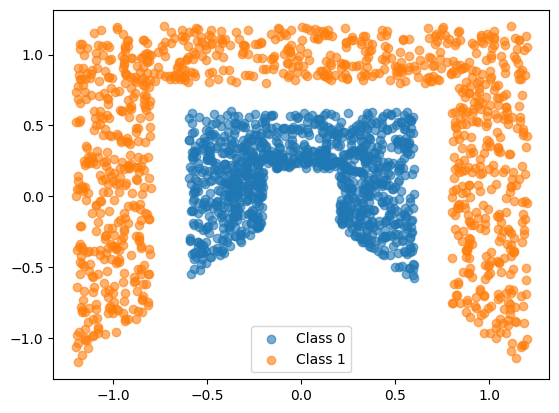

In [969]:
# load the dataset
df= pd.read_csv('datasets/concentric_dataset.csv')
# print(df)
X = df[['X1', 'X2']].values
y = df['y'].values

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Plot the dataset (optional for visualization)
plt.scatter(X[y == 0][:, 0], X[y == 0][:, 1], label='Class 0', alpha=0.6)
plt.scatter(X[y == 1][:, 0], X[y == 1][:, 1], label='Class 1', alpha=0.6)
plt.legend()
plt.show()

In [970]:
def online_dataset_preprocess():

    csv_path = "datasets/concentric_dataset.csv"
    df = pd.read_csv(csv_path)
    target = 'y'

    X, y = preprocessor(df, target)
    X_train, X_val, X_test, y_train, y_val, y_test = train_val_test_split(X, y)

    return X_train, X_val, X_test, y_train, y_val, y_test

# Dataset 1

In [971]:
# csv_path = "datasets/WA_Fn-UseC_-Telco-Customer-Churn.csv"
# df = pd.read_csv(csv_path)
# df.head()

In [972]:
# # Preprocess data
# target = 'Churn'
# # drop customerID column
# df.drop(columns=['customerID'], inplace=True)

# # convert TotalCharges to numeric
# df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

# X, y = preprocessor(df, target)

In [973]:
# # Split data into training, validation and test sets
# X_train, X_val, X_test, y_train, y_val, y_test = train_val_test_split(X, y)

# X_train.info()

# Dataset 2

In [974]:
# # columns from adult.names
# cols = ['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship',
#          'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country', 'income']

In [975]:
# csv_train_path = "datasets/adult/adult.data"
# csv_test_path = "datasets/adult/adult.test"

In [976]:
# train_df = pd.read_csv(csv_train_path,names=cols)
# train_df['train'] = 1
# train_df.info()

In [977]:
# test_df = pd.read_csv(csv_test_path, names=cols, skiprows=1)
# test_df['train'] = 0
# test_df.info()

In [978]:
# # Combine train and test data
# df = pd.concat([train_df, test_df])

In [979]:
# columns = df.columns
# # print unique values in each column except numericals ones
# num_cols = df.select_dtypes(include=[np.number]).columns
# non_num_cols = columns.difference(num_cols)

# for col in non_num_cols:
#     print("\033[1m"+col + "\033[0m")
#     print(df[col].unique())
#     print("\n")

In [980]:
# for col in num_cols:
#     print("\033[1m"+col + "\033[0m")
#     print(df[col].unique())
#     print("\n")

In [981]:
# # special preprocessing for the adult dataset
# target = 'income'
# # education and education-num are the same, so we can drop one of them
# df.drop(columns=['education'], inplace=True)

In [982]:

# # convert age,education_num,capital_gain,capital_loss,hours_per_week data type to category
# df['age'] = df['age'].astype('category')

# df['education-num'] = df['education-num'].astype('category')

# # train_df['capital-gain'] = train_df['capital-gain'].astype('category')
# # test_df['capital-gain'] = test_df['capital-gain'].astype('category')

# # train_df['capital-loss'] = train_df['capital-loss'].astype('category')
# # test_df['capital-loss'] = test_df['capital-loss'].astype('category')

# df['hours-per-week'] = train_df['hours-per-week'].astype('category')

In [983]:
# df[target].unique()
# df[target] = df[target].str.replace(".", "")
# df[target].unique()

In [984]:
# replace_missing_values(df)
# drop_target_nan(df, target)
# df[target] = encode_target(df[target])
# df = encode_categorical_features(df)
# df = scaling(df)
# df = feature_selection(df, df[target])

In [985]:
# train_df = df[df['train'] == 1]
# test_df = df[df['train'] == 0]

In [986]:
# train_df.drop(columns=['train'], inplace=True)
# X_train, y_train = create_io_features(train_df, target)

In [987]:
# test_df.drop(columns=['train'], inplace=True)
# X_test, y_test = create_io_features(test_df, target)

In [988]:
# from sklearn.model_selection import train_test_split

# X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=0)

# Dataset 3

In [989]:
# csv_path = "datasets/creditcard.csv"
# creditcard_df = pd.read_csv(csv_path)
# creditcard_df.head()

In [990]:
# fraud_df = creditcard_df[creditcard_df['Class'] == 1]
# non_fraud_df = creditcard_df[creditcard_df['Class'] == 0].sample(20000)

# df = pd.concat([fraud_df, non_fraud_df])

In [991]:
# special preprocessing for the creditcard dataset
# target = 'Class'

In [992]:
# # general preprocessing for the creditcard dataset
# X, y = preprocessor(df, target)
# X.info()

# Playground

`splitting into train,validation and test`

In [993]:
# X_train, X_val, X_test, y_train, y_val, y_test = dataset1_preprocess()
# X_train, X_val, X_test, y_train, y_val, y_test = dataset2_preprocess()
# X_train, X_val, X_test, y_train, y_val, y_test = dataset3_preprocess()
X_train, X_val, X_test, y_train, y_val, y_test = online_dataset_preprocess()

In [994]:
print(X_train.shape)

(1280, 2)


`Training & Testing on Library Model`

In [995]:
# library logistic regression without bagging or stacking
lr = LogisticRegression()
lr.fit(X_train, y_train)
print("Library Logistic Regression(w/o bagging or stacking)")
print(evaluate_model(lr, X_test, y_test))


Library Logistic Regression(w/o bagging or stacking)
{'accuracy': 0.5975, 'sensitivity': 0.5882352941176471, 'specificity': 0.6071428571428571, 'precision': 0.6091370558375635, 'f1_score': 0.5985037406483791, 'auroc': 0.6082933173269307, 'aupr': 0.7599763241002875}


In [996]:
meta_model, base_models = stacking_ensemble(X_train, y_train, X_val, y_val, custom=False)

In [997]:
X_test_meta = np.column_stack([X_test] + [model.predict(X_test) for model in base_models])

eval = evaluate_model(meta_model, X_test_meta, y_test)
print("Library Logistic Regression with bagging and Stacking")
print(eval)

Library Logistic Regression with bagging and Stacking
{'accuracy': 0.6325, 'sensitivity': 0.5637254901960784, 'specificity': 0.7040816326530612, 'precision': 0.6647398843930635, 'f1_score': 0.610079575596817, 'auroc': 0.6696678671468588, 'aupr': 0.6827967115318454}


`Training & Testing on Custom Model`

In [998]:
clr = CustomLogisticRegression()
clr.fit(X_train, y_train)
print("Custom Logistic Regression(w/o bagging or stacking)")
print(evaluate_model(clr, X_test, y_test))

Custom Logistic Regression(w/o bagging or stacking)
{'accuracy': 0.5975, 'sensitivity': 0.5882352941176471, 'specificity': 0.6071428571428571, 'precision': 0.6091370558375635, 'f1_score': 0.5985037406483791, 'auroc': 0.6082933173269308, 'aupr': 0.7601145437464681}


In [999]:
meta_model, base_models = stacking_ensemble(X_train, y_train, X_val, y_val, custom=True)

In [1000]:
X_test_meta = np.column_stack([X_test] + [model.predict(X_test) for model in base_models])

meta_eval = evaluate_model(meta_model, X_test_meta, y_test)
print("Custom Logistic Regression with bagging and Stacking")
print(meta_eval)

Custom Logistic Regression with bagging and Stacking
{'accuracy': 0.6325, 'sensitivity': 0.5980392156862745, 'specificity': 0.6683673469387755, 'precision': 0.6524064171122995, 'f1_score': 0.6240409207161125, 'auroc': 0.6941026410564226, 'aupr': 0.7474054915819442}


In [1001]:
lr_eval = LR_eval(base_models, X_test, y_test)
lr_eval.mean(), lr_eval.std()

(accuracy       0.601944
 sensitivity    0.581155
 specificity    0.623583
 precision      0.618323
 f1_score       0.598522
 auroc          0.608424
 aupr           0.759922
 dtype: float64,
 accuracy       0.023378
 sensitivity    0.013671
 specificity    0.057201
 precision      0.032241
 f1_score       0.011850
 auroc          0.001229
 aupr           0.000955
 dtype: float64)

In [1002]:
voting_eval = majority_voting_eval(majority_voting(base_models, X_test), y_test)
voting_eval

{'accuracy': 0.5975,
 'sensitivity': 0.5882352941176471,
 'specificity': 0.6071428571428571,
 'precision': 0.6091370558375635,
 'f1_score': 0.5985037406483791,
 'auroc': 0.5976890756302522,
 'aupr': 0.5683159151985667}

+-------------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+
| Performance on Test set |      Accuracy     |    Sensitivity    |    Specificity    |     Precision     |      F1-score     |       AUROC       |        AUPR       |
+-------------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+
|      LR(avg ± std)      | 0.60194 ± 0.02338 | 0.58115 ± 0.01367 | 0.62358 ± 0.05720 | 0.61832 ± 0.03224 | 0.59852 ± 0.01185 | 0.60842 ± 0.00123 | 0.75992 ± 0.00095 |
|     Voting ensemble     |      0.59750      |      0.58824      |      0.60714      |      0.60914      |      0.59850      |      0.59769      |      0.56832      |
|    Stacking ensemble    |      0.63250      |      0.59804      |      0.66837      |      0.65241      |      0.62404      |      0.69410      |      0.74741

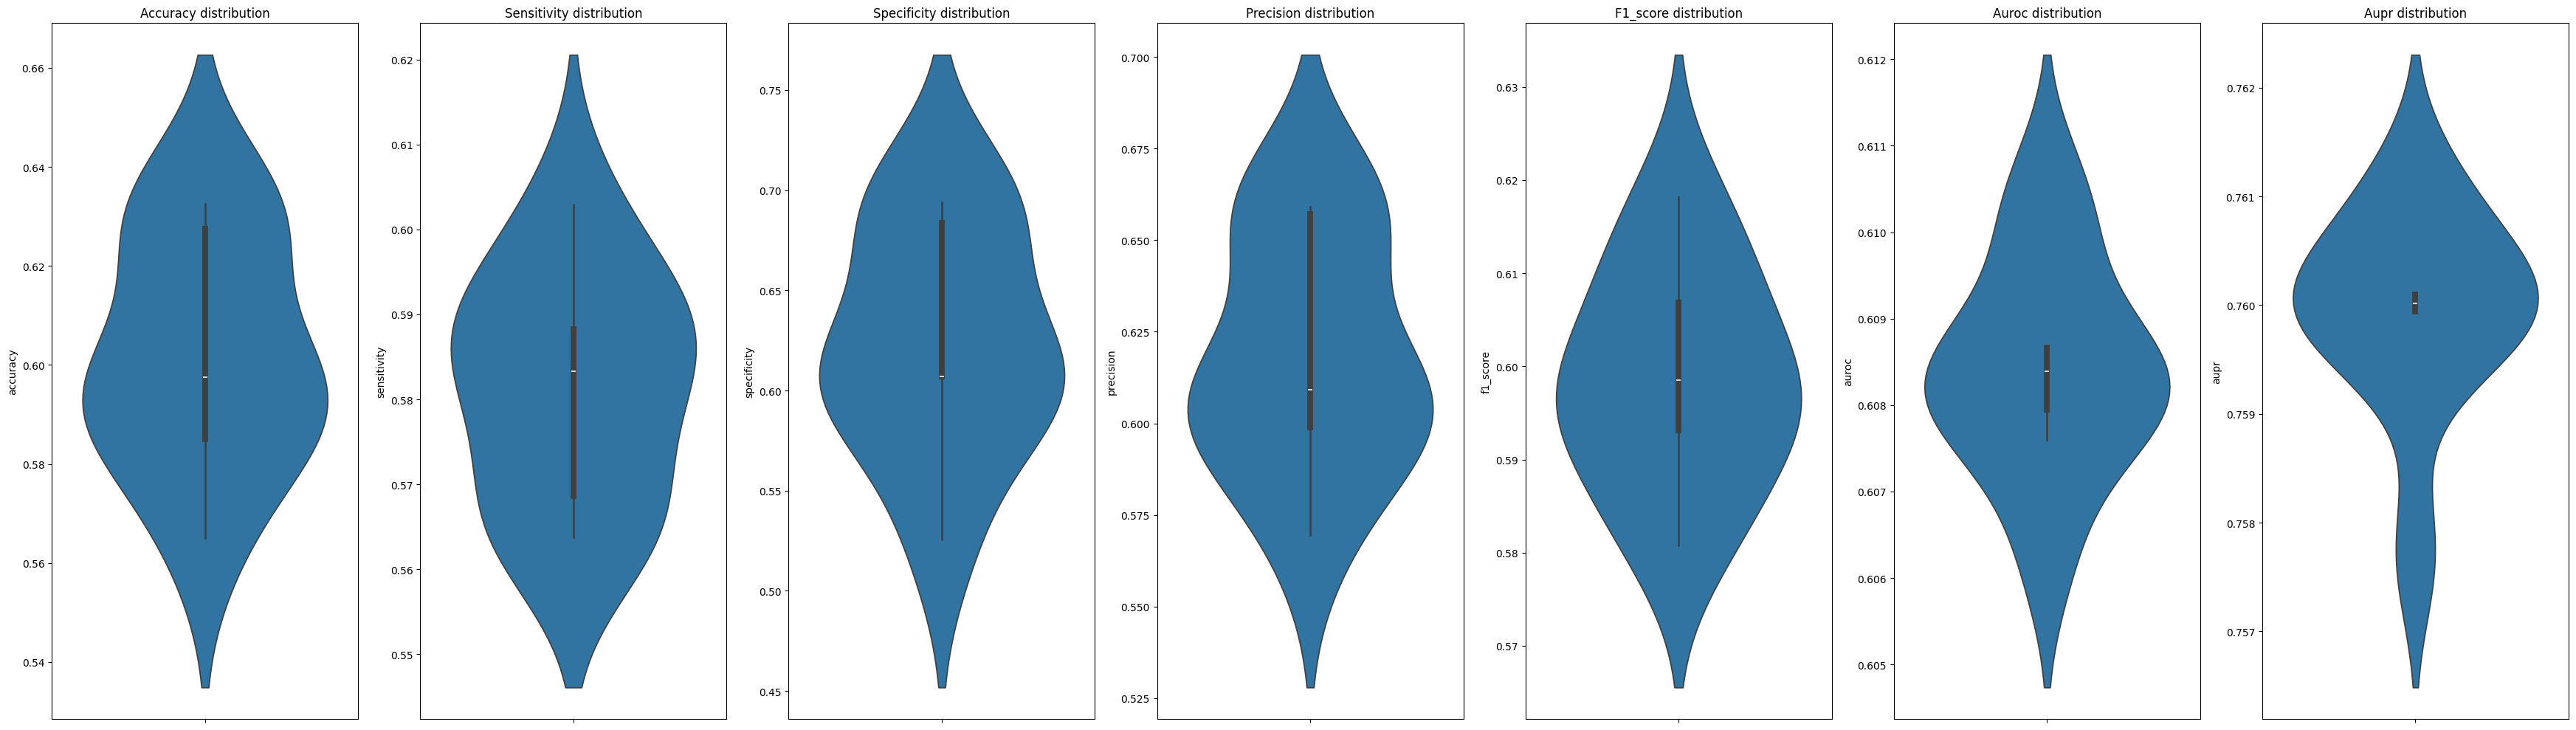

In [1003]:
print_table(lr_eval,meta_eval,voting_eval)
draw_violin_plots(lr_eval)

In [1004]:
# X_m = pd.DataFrame(X_test, columns=X_test.columns.tolist() + [f"model_{i}" for i in range(len(base_models))])
# coeff_df = pd.DataFrame(meta_model.weights[1:], X_m.columns, columns=['Coefficient'])
# coeff_df

In [1005]:
# # plot the coefficients
# import matplotlib.pyplot as plt
# coeff_df.plot(kind='bar', figsize=(10, 6))
# plt.ylabel('Coefficient Value')
# plt.title('Feature Coefficients')
# plt.show()
